# Stable Diffusion Deep Dive

Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import FlaxStableDiffusionPipeline

pipeline, pipeline_params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="bf16", dtype=jax.numpy.bfloat16
)

prng_seed = jax.random.PRNGKey(seed)
prompt = num_samples * [prompt]
prompt_ids = pipeline.prepare_inputs(prompt)

# shard inputs and rng
params = replicate(pipeline_params)
prng_seed = jax.random.split(prng_seed, num_samples)
prompt_ids = shard(prompt_ids)

images = pipeline(prompt_ids, params, prng_seed).images
images = np.asarray(images.reshape((num_samples,) + images.shape[-3:]))
images = pipeline.numpy_to_pil(images)
```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like. 

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
%%capture
%%bash

pip install --upgrade scipy flax
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade diffusers transformers

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

In [5]:
from diffusers import FlaxAutoencoderKL, FlaxUNet2DConditionModel, FlaxPNDMScheduler

## Loading the models

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [6]:
dtype = jax.numpy.float16

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"
revision = "bf16" # "flax"

In [8]:
tokenizer = CLIPTokenizer.from_pretrained(model_id, revision=revision, subfolder="tokenizer", dtype=dtype)
text_encoder = FlaxCLIPTextModel.from_pretrained(model_id, revision=revision, subfolder="text_encoder", dtype=dtype)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at CompVis/stable-diffusion-v1-4:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'bias'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'out_pro

In [9]:
vae, vae_params = FlaxAutoencoderKL.from_pretrained(model_id, revision=revision, subfolder="vae", dtype=dtype)
unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(model_id, revision=revision, subfolder="unet", dtype=dtype)

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

In [10]:
scheduler, scheduler_params = FlaxPNDMScheduler.from_pretrained(model_id, revision=revision, subfolder="scheduler")

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

## Diffusion Loop

In [11]:
seed = 123
num_samples = jax.device_count()
prng_seed = jax.random.PRNGKey(seed)
prng_seed = jax.random.split(prng_seed, num_samples)

In [12]:
guidance_scale = 7.5 #@param {type:"slider", min:0, max:100, step:0.5}
num_inference_steps = 30 #@param

In [40]:
prompt = "a photo of a car orbiting earth in van Gogh style"

In [41]:
text_encoder_params = None

In [42]:
%%time

# init
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)

# prepare_inputs
text_input = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
prompt_ids = text_input.input_ids

# call
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor

# _generate

# get prompt text embeddings
text_embeddings = text_encoder(prompt_ids, params=text_encoder_params)[0]

batch_size = prompt_ids.shape[0]

max_length = prompt_ids.shape[-1]

uncond_input = tokenizer(
  [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
).input_ids

uncond_embeddings = text_encoder(uncond_input, params=text_encoder_params)[0]
context = jnp.concatenate([uncond_embeddings, text_embeddings])

latents_shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)

def diffusion_loop(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)
    
    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])
    
    latents_input = scheduler.scale_model_input(scheduler_state, latents_input, t)
    
    # predict the noise residual
    noise_pred = unet.apply(
        {"params": unet_params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=context,
        ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents, scheduler_state = scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
    
    return latents, scheduler_state

# set the timestamps based on the number of steps
scheduler_state = scheduler.set_timesteps(
    scheduler_params, num_inference_steps=num_inference_steps, shape=latents.shape
    )
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.init_noise_sigma

latents, _ = jax.lax.fori_loop(0, num_inference_steps, diffusion_loop, (latents, scheduler_state))

CPU times: user 40min, sys: 14.1 s, total: 40min 14s
Wall time: 21min 38s


In [45]:
latents.shape

(1, 4, 64, 64)

In [22]:
def latents_to_pil(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    images = vae.apply({"params": vae_params}, latents, method=vae.decode).sample
    # convert JAX to numpy
    images = (images / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    images = np.asarray(images)
    # convert numpy array to PIL
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [43]:
%%time

images = latents_to_pil(latents)

CPU times: user 1min 4s, sys: 1.44 s, total: 1min 6s
Wall time: 38.4 s


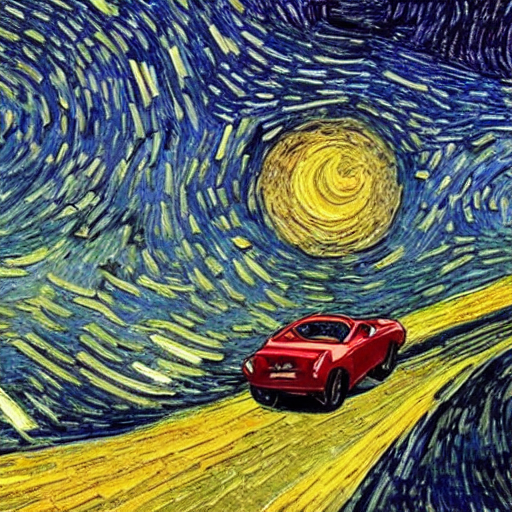

In [44]:
images[0]

## The Autoencoder (AE)

The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [13]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224 

In [14]:
pil_image = Image.open('flower.jpeg')

In [24]:
def pil_to_latents(pil_image):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    image = np.asarray(pil_image)
    image = jax.image.resize(image, (512, 512, 3), "bicubic")
    image = (image / 127.5 - 1.0).astype(np.float32)
    input_im = jnp.expand_dims(image, axis=0)
    input_im = jnp.transpose(input_im, (0, 3, 1, 2))
    # encode the image
    latents = vae.apply({"params": vae_params}, input_im, method=vae.encode)
    return 0.18215 * latents.latent_dist.sample(prng_seed)

In [25]:
%%time

flower_latents = pil_to_latents(pil_image)

CPU times: user 31.5 s, sys: 627 ms, total: 32.2 s
Wall time: 21 s


In [38]:
def plot_latents(latents, figsize=(10, 5), maintitle=None):
    latents = latents.squeeze()
    rows, cols = 1, latents.shape[-1]
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.set_title('Channel '+str(i), fontsize=16)
        img = np.asarray(latents[:, :, i])
        plt.imshow(img)

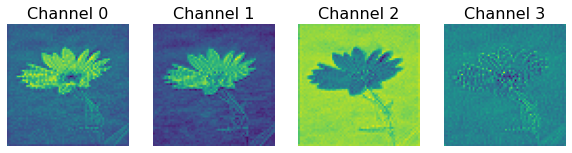

In [39]:
plot_latents(flower_latents)

In [35]:
%%time

images = latents_to_pil(flower_latents)

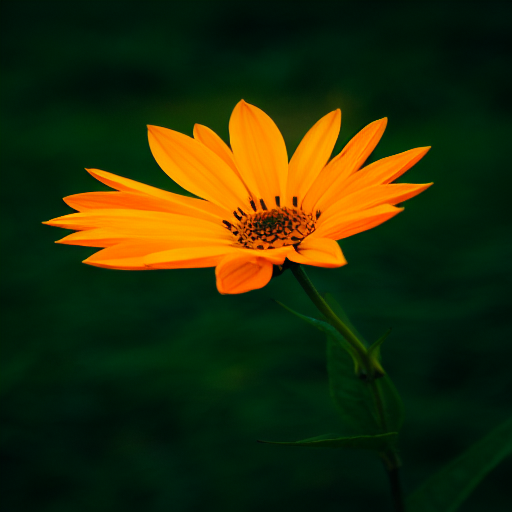

In [36]:
images[0]

## The Scheduler
Now we need to talk about adding noise...

During training, we add some noise to an image an then have the model try to predict the noise. If we always added a ton of noise, the model might not have much to work with. If we only add a tiny amount, the model won't be able to do much with the random starting points we use for sampling. So during training the amount is varied, according to some distribution.

During sampling, we want to 'denoise' over a number of steps. How many steps and how much noise we should aim for at each step are going to affect the final result.

The scheduler is in charge of handling all of these details. For example: `scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)` sets up a scheduler that matches the one used to train this model. When we want to sample over a smaller number of steps, we set this up with `scheduler.set_timesteps`:

In [ ]:
flower_latents.shape

In [ ]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display